# 3D (x-y-t) field inference with nu: ensemble experiments

We start from a flow field generated with `drifter_3D.ipynb` and run multiple inferences with different draws of  mooring positions & drifters release positions as well as noise.

**Production**: runs are actually produced from scripts: `launch.pbs` and `drifter_3D_ensemble.py`

In [5]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
from pandas.api.types import is_number
import xarray as xr
import dask

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import corner
import arviz as az

import nwastats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

In [2]:
# actually run production inferences
#prod=True
prod=False

local_cluster = True
if prod:
    local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' ha

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32867,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:60241,Total threads: 7
Dashboard: http://127.0.0.1:41730/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:58074,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [17]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # deactivates time scale inference - need overhaul
no_space = False # deactivates spatial scale inference
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters
#enable_nu = False # enable estimation of spectral slopes
enable_nu = True # enable estimation of spectral slopes

if no_space:
    # makes little sense otherwise
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"

# number of points used for inference#
#Nxy, Nt = 1, 50
#Nxy, Nt = 2, 50
#Nxy, Nt = 4, 50
#Nxy, Nt = 16, 50

Nxy, Nt = 8, 50 # reference case

#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# run multiple Nxy at once
#Nxy = [1, 2, 4, 8, 16]

# number of ensembles
#Ne = 10 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms
#dx = [20, 50, 100, 150, 200]
dx = ("spiral", 50, 300)

burn = 500 # number of samples to drop (burning)

psuffix, osuffix = None, None
#psuffix = "_spiral"
#osuffix = "_lprior"

In [4]:
# prepare inference & common utils
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation,
    traj_decorrelation,
    enable_nu,
)
flow_attrs = dict(**dsf.attrs)
truth = {k: v for k, v in zip(labels, [noise]+covparams)}

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0


---
## run/load inferences

### moorings

In [5]:
# dev
#ds = st.run_mooring_ensembles(5, dsf, covparams, covfunc, labels, (Nt, Nxy), noise, n_mcmc=100)

In [18]:
def run_mooring(Nxy, dx):    
    print(f"Nxy = {Nxy}, dx={dx}")
    
    # build output file name
    nc = os.path.join(run_dir, f"moorings_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        if is_number(dx):
            nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
        elif isinstance(dx, tuple):
            nc = nc.replace(".nc", f"_{dx[0]}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    if enable_nu:
        nc = nc.replace(".nc", f"_nu.nc")
    if osuffix is not None:
        nc = nc.replace(".nc", osuffix+".nc")

    if prod and not os.path.isfile(nc):
        ds = st.run_mooring_ensembles(
            Ne, dsf, covparams, covfunc, labels, (Nt, Nxy), noise, dx=dx,
            no_time=no_time, no_space=no_space,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    if ds.parameter.size==4:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    elif ds.parameter.size==6:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'νs', 'νt', 'σ'])

    return ds

if isinstance(dx, list):
    Dm = []
    for d in dx:
        Dm.append(run_mooring(Nxy, d))
    ds = Dm[0]
elif isinstance(Nxy, list):
    Dm = []
    for n in Nxy:
        Dm.append(run_mooring(n, dx))
    ds = Dm[0]
else:
    ds = run_mooring(Nxy, dx)

mo = ds

Nxy = 8, dx=('spiral', 50, 300)


### drifters

- Lagrangian simulation
- actual inference


In [19]:
# dev
#ds = st.run_drifter_ensembles(data_dir, case, Ne, covparams, covfunc, labels, (Nt, Nxy), noise, n_mcmc=100) # dev: delete None

# wrapper
def run_drifter(Nxy, dx):
    print(f"Nxy = {Nxy}, dx={dx}")

    # build output file name    
    nc = os.path.join(run_dir, f"drifters_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        if is_number(dx):
            nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
        elif isinstance(dx, tuple):
            nc = nc.replace(".nc", f"_{dx[0]}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    if enable_nu:
        nc = nc.replace(".nc", f"_nu.nc")
    if osuffix is not None:
        nc = nc.replace(".nc", osuffix+".nc")

    if prod and not os.path.isfile(nc):
        ds = st.run_drifter_ensembles(
            data_dir, case, Ne, covparams, covfunc, labels, (Nt, Nxy), noise, dx=dx,
            no_time=no_time, no_space=no_space,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
    
    # move noise last
    if ds.parameter.size==4:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    elif ds.parameter.size==6:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'νs', 'νt', 'σ'])
    
    return ds

if isinstance(dx, list):
    Dr = []
    for d in dx:
        Dr.append(run_drifter(Nxy, d))
    ds = Dr[0]
elif isinstance(Nxy, list):
    Dr = []
    for n in Nxy:
        Dr.append(run_drifter(n, dx))
    ds = Dr[0]
else:
    ds = run_drifter(Nxy, dx)

dr = ds

Nxy = 8, dx=('spiral', 50, 300)


---

## joint mooring/drifters inference performance

In [20]:
mo["lower"].mean("ensemble"), mo["upper"].mean("ensemble")

(<xarray.DataArray 'lower' (parameter: 6)> Size: 48B
 array([0. , 0. , 0. , 1. , 0.1, 0. ])
 Coordinates:
   * parameter  (parameter) <U2 48B 'γ' 'λx' 'λt' 'νs' 'νt' 'σ',
 <xarray.DataArray 'upper' (parameter: 6)> Size: 48B
 array([7.74596669e-01, 1.00000000e+03, 5.00000000e+01, 5.00000000e+00,
        5.00000000e+00, 1.00000000e-01])
 Coordinates:
   * parameter  (parameter) <U2 48B 'γ' 'λx' 'λt' 'νs' 'νt' 'σ')

In [21]:
def show_IQW(ds):
    Q = [1/4,1/2,3/4]
    da = ds.MAP.quantile(Q, "ensemble")
    #for q in da["quantile"]:
    #    _da = da.sel(quantile=q)
    #    #print("quantile={q}"+_da.data)

    _da = da.sel(quantile=Q[1])
    print("% median: "+" , ".join([f"{p.data}={float(_da.sel(parameter=p)):.3f}" for p in da.parameter]))

    _da = da.sel(quantile=Q[2]) - da.sel(quantile=Q[0])
    print("% IQW: "+" , ".join([f"{p.data}={float(_da.sel(parameter=p)):.3f}" for p in da.parameter]))
    _da = _da/da.sel(quantile=Q[1])
    print("% IQW normalized: "+" , ".join([f"{p.data}={float(_da.sel(parameter=p)):.2f}" for p in da.parameter]))
    #print(_da)
    

print("%%% Moorings")
show_IQW(mo)

print("%%% Drifters")
show_IQW(dr)

%%% Moorings
% median: γ=0.078 , λx=100.943 , λt=5.121 , νs=2.519 , νt=0.503 , σ=0.010
% IQW: γ=0.007 , λx=10.447 , λt=0.937 , νs=0.304 , νt=0.106 , σ=0.002
% IQW normalized: γ=0.09 , λx=0.10 , λt=0.18 , νs=0.12 , νt=0.21 , σ=0.19
%%% Drifters
% median: γ=0.078 , λx=98.990 , λt=4.928 , νs=2.601 , νt=0.520 , σ=0.010
% IQW: γ=0.006 , λx=8.916 , λt=1.071 , νs=0.409 , νt=0.114 , σ=0.004
% IQW normalized: γ=0.08 , λx=0.09 , λt=0.22 , νs=0.16 , νt=0.22 , σ=0.42


In [25]:
bounds = dict(
    σ=(0.,.04),
    #γ=(truth["γ"]*.5,truth["γ"]*1.5),
    γ=(truth["γ"]*.75,truth["γ"]*1.25),
    λx=(50,150),
    λt=(2.5,10),
    #νs=(2,3),
    #νt=(0,1),
    νs=(1,5),
    νt=(0,5),
)

In [33]:
# MAP distribution

def plot():

    fig, axes = plt.subplot_mosaic(
        [['(a)', '(b)', '(c)',], ['(d)', '(e)', '(f)']],
        layout='constrained',
        figsize=(10,6),
        dpi=300,
    )
    
    #fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))
    #axes = axes.flatten()
    
    alpha = 0.5
    
    nbins = 30
    bins = dict(
        σ=np.linspace(0,.03,nbins),
        γ=np.linspace(0.75, 1.25,nbins)*float(mo.true_parameters.sel(parameter="γ", ensemble=0)),
        λx=np.linspace(50,150,nbins),
        λt=np.linspace(2.5,10,nbins),
        #νs=np.linspace(2,3,nbins),
        #νt=np.linspace(0,1,nbins),
        νs=np.linspace(1,5,nbins),
        νt=np.linspace(0,1,nbins),
    )
    units = dict(
        σ="[m/s]",
        #η="[m/s x km]",
        γ="[m/s]",
        λx="[km]",
        λt="[days]",
        νs="[1]",
        νt="[1]",
    )

    labels = mo.parameter.values
    labels = [r"${}_{}$".format(l[0], "s") if l=="λx" else l for l in labels]
    labels = [r"${}_{}$".format(l[0], "t") if l=="λt" else l for l in labels]    
    
    ds = mo
    for p, kax, l in zip(ds.parameter, axes, labels):
        _p = str(p.values)
        ax = axes[kax]
        _ds = ds.sel(parameter=p)
        _tr = float(_ds.true_parameters.isel(ensemble=0))
        #check whether we need to correct:
        if (p=="γ" or p=="η"):
            if 'velocity_deficit' in flow_attrs:
                _s = flow_attrs['velocity_deficit']
            else:
                _s = st.amplitude_decifit(
                    flow_attrs["dx"], flow_attrs["lambda_x"], flow_attrs["nu_space"],
                )
            #_tr = _tr*_s
        _ds.MAP.plot.hist(
            ax=ax, bins=bins[_p], 
            color=colors["mo"], alpha=alpha, 
            label="moorings", 
            zorder=10,
        )
        #ax.set_title(str(p.values)) #+ " - MAP"
        # truth
        ax.axvline(_tr, color=colors["truth"], lw=4)
        # interquartile width
        _qt = _ds.MAP.quantile([1/4,3/4], "ensemble")
        for q in _qt["quantile"]:
            ax.axvline(float(_qt.sel(quantile=q)), color="0.5", lw=2, ls="--")

        ax.grid()
        #print(bins[_p][0,-1])
        ax.set_xlim(bins[_p][0], bins[_p][-1])
    
    ds = dr
    for p, kax, l in zip(ds.parameter, axes, labels):
        _p = str(p.values)
        ax = axes[kax]
        _ds = ds.sel(parameter=p)
        #_tr = float(_ds.true_parameters.isel(ensemble=0))
        _ds.MAP.plot.hist(
            ax=ax, bins=bins[_p],
            color=colors["dr"], alpha=alpha, 
            label="drifters", 
            zorder=10,
        )
        ax.set_title(l + " MAP")
        #ax.axvline(_tr, color="k", lw=4)
        ax.set_xlabel(units[_p])
        if ax==axes["(d)"]:
            ax.legend()

    figname = flow_attrs["cov_x"]+"_refcase_inference_ensemble_MAP_nu"
    if osuffix is not None:
        figname = figname + osuffix
    st.label_and_print(fig, axes, figname)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_refcase_inference_ensemble_MAP_nu.eps .
scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_refcase_inference_ensemble_MAP_nu.png .


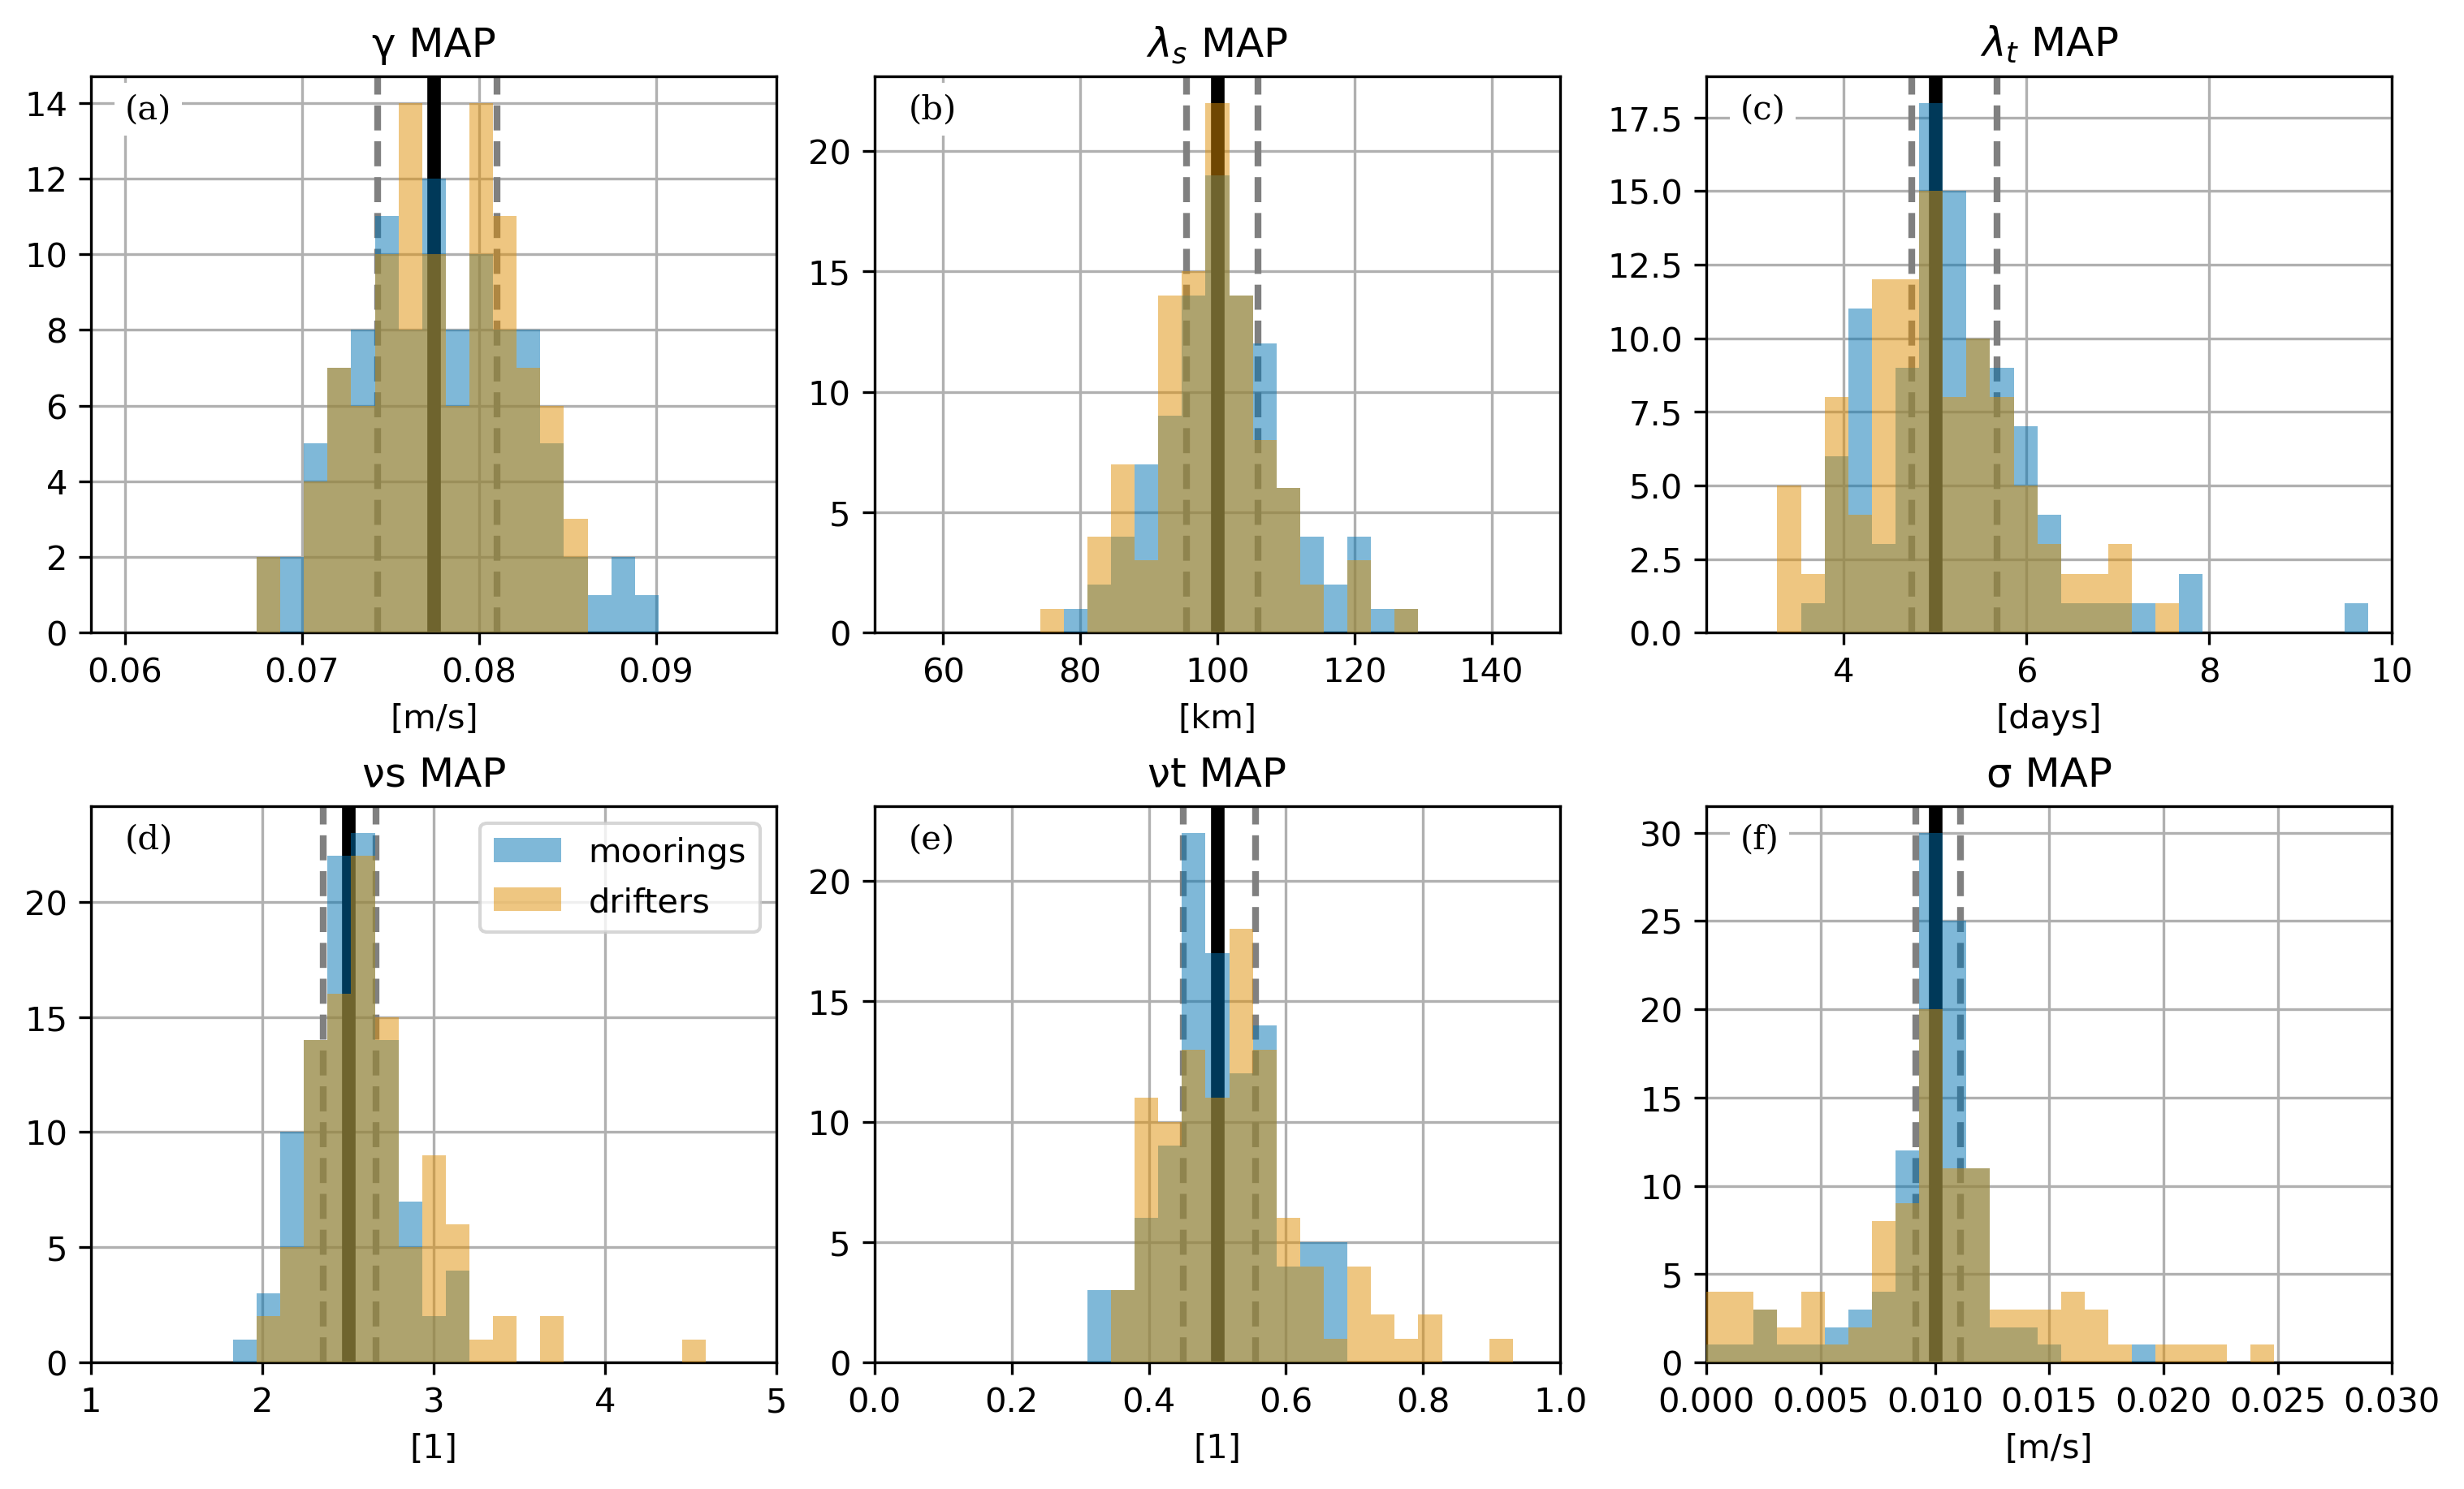

In [34]:
plot()

In [30]:
# print MCMC normalized step size
" / ".join([f"{v:.2f}" for v in (mo.steps/mo.true_parameters).isel(ensemble=0).data])

'0.05 / 0.05 / 0.05 / 0.05 / 0.05 / 0.05'

Text(0.5, 1.0, 'mean value = 25%')

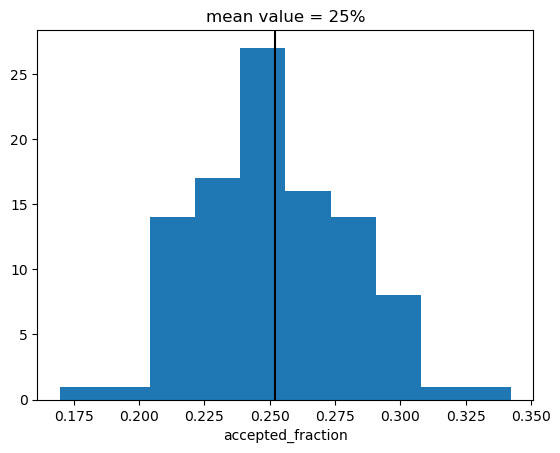

In [31]:
# show accepted fraction
fig, ax = plt.subplots(1,1)
da = mo.accepted_fraction
da.plot.hist(ax=ax)
ax.axvline(da.mean(), color="k")
ax.set_title(f"mean value = {float(da.mean().data)*100:.0f}%")

Text(0.5, 1.0, 'mean value = 29%')

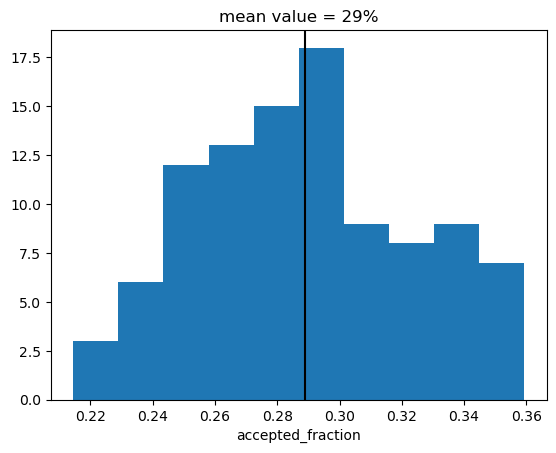

In [32]:
# show accepted fraction
fig, ax = plt.subplots(1,1)
da = dr.accepted_fraction
da.plot.hist(ax=ax)
ax.axvline(da.mean(), color="k")
ax.set_title(f"mean value = {float(da.mean().data)*100:.0f}%")

averaged effective sample size:  γ / λx / λt / νs / νt / σ
23 / 32 / 48 / 17 / 25 / 7
averaged effective sample size:  γ / λx / λt / νs / νt / σ
35 / 39 / 27 / 23 / 19 / 8


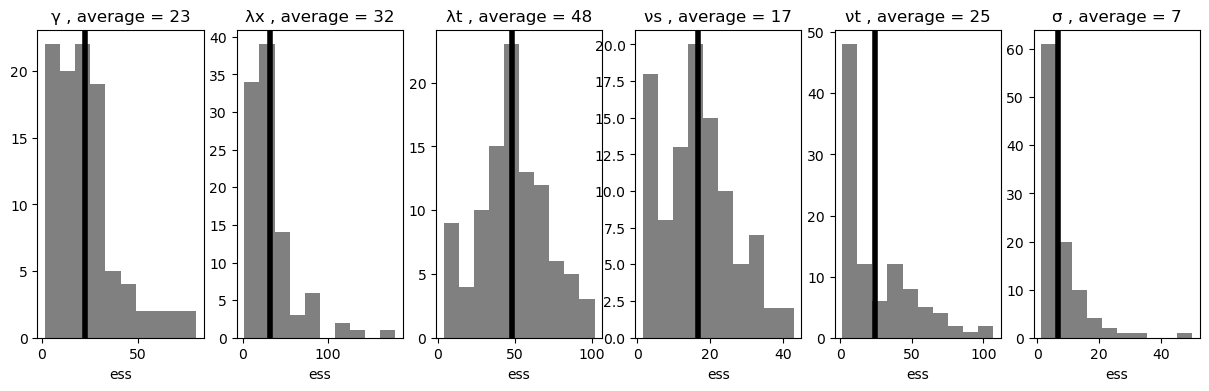

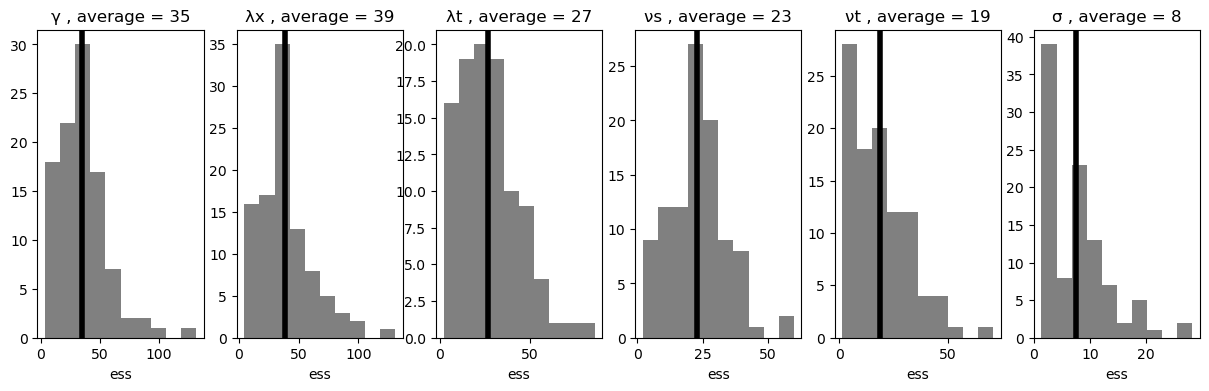

In [19]:
# inspect effective sample size
st.show_ess(mo)
st.show_ess(dr)

---
## mooring inference plot

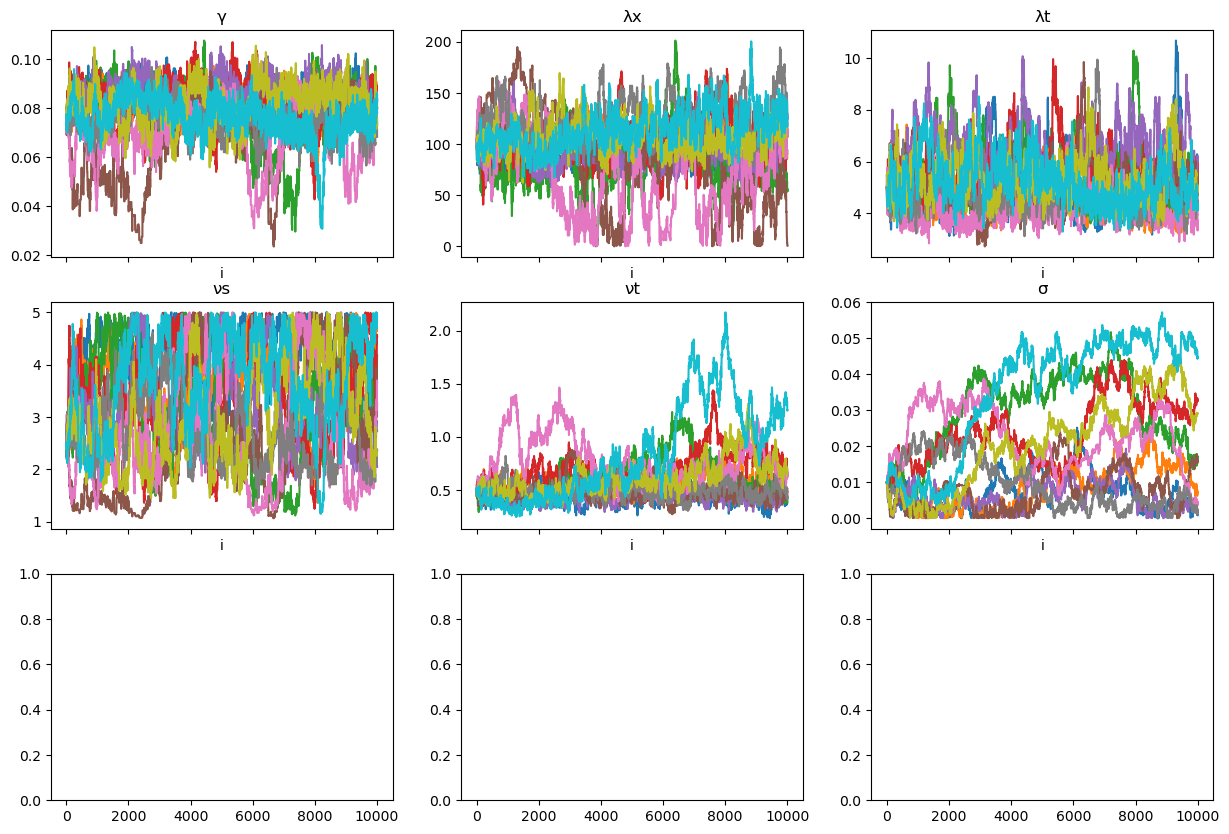

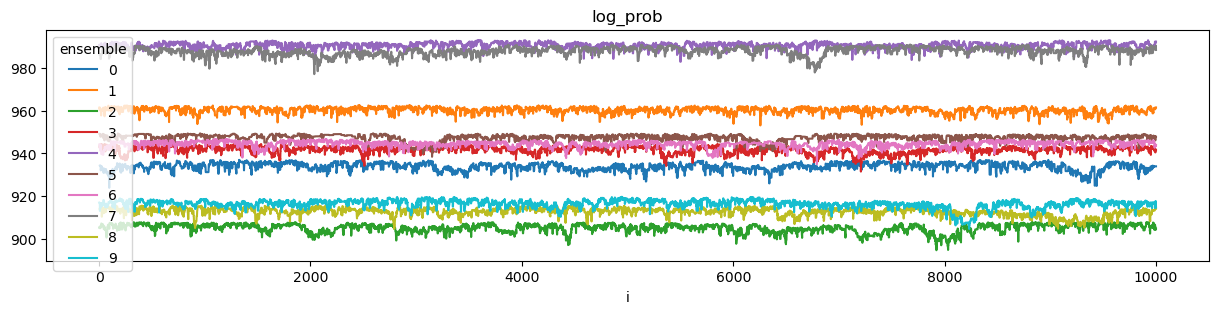

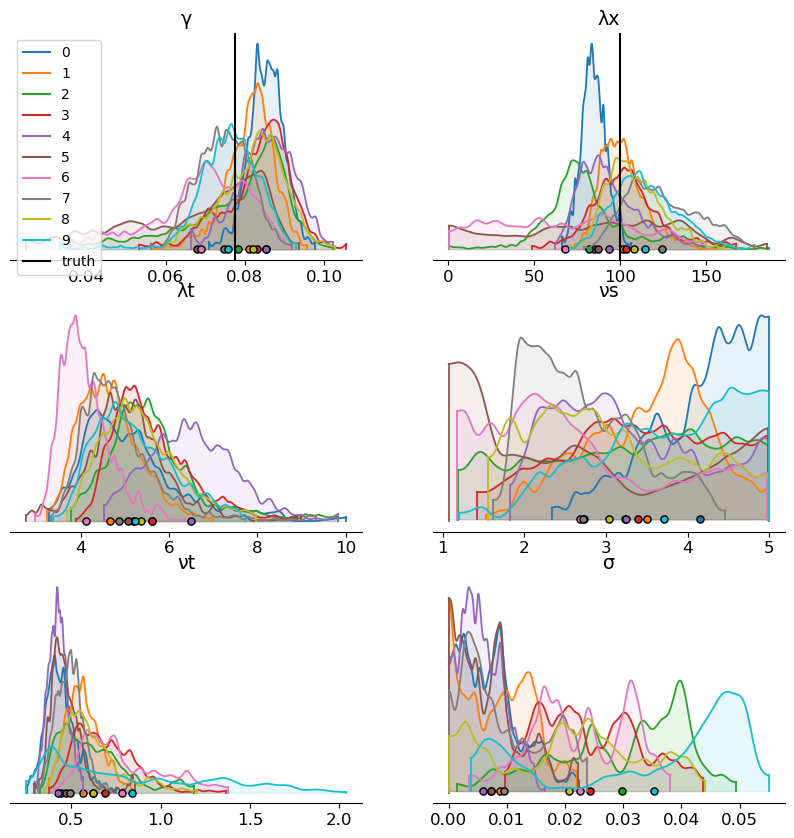

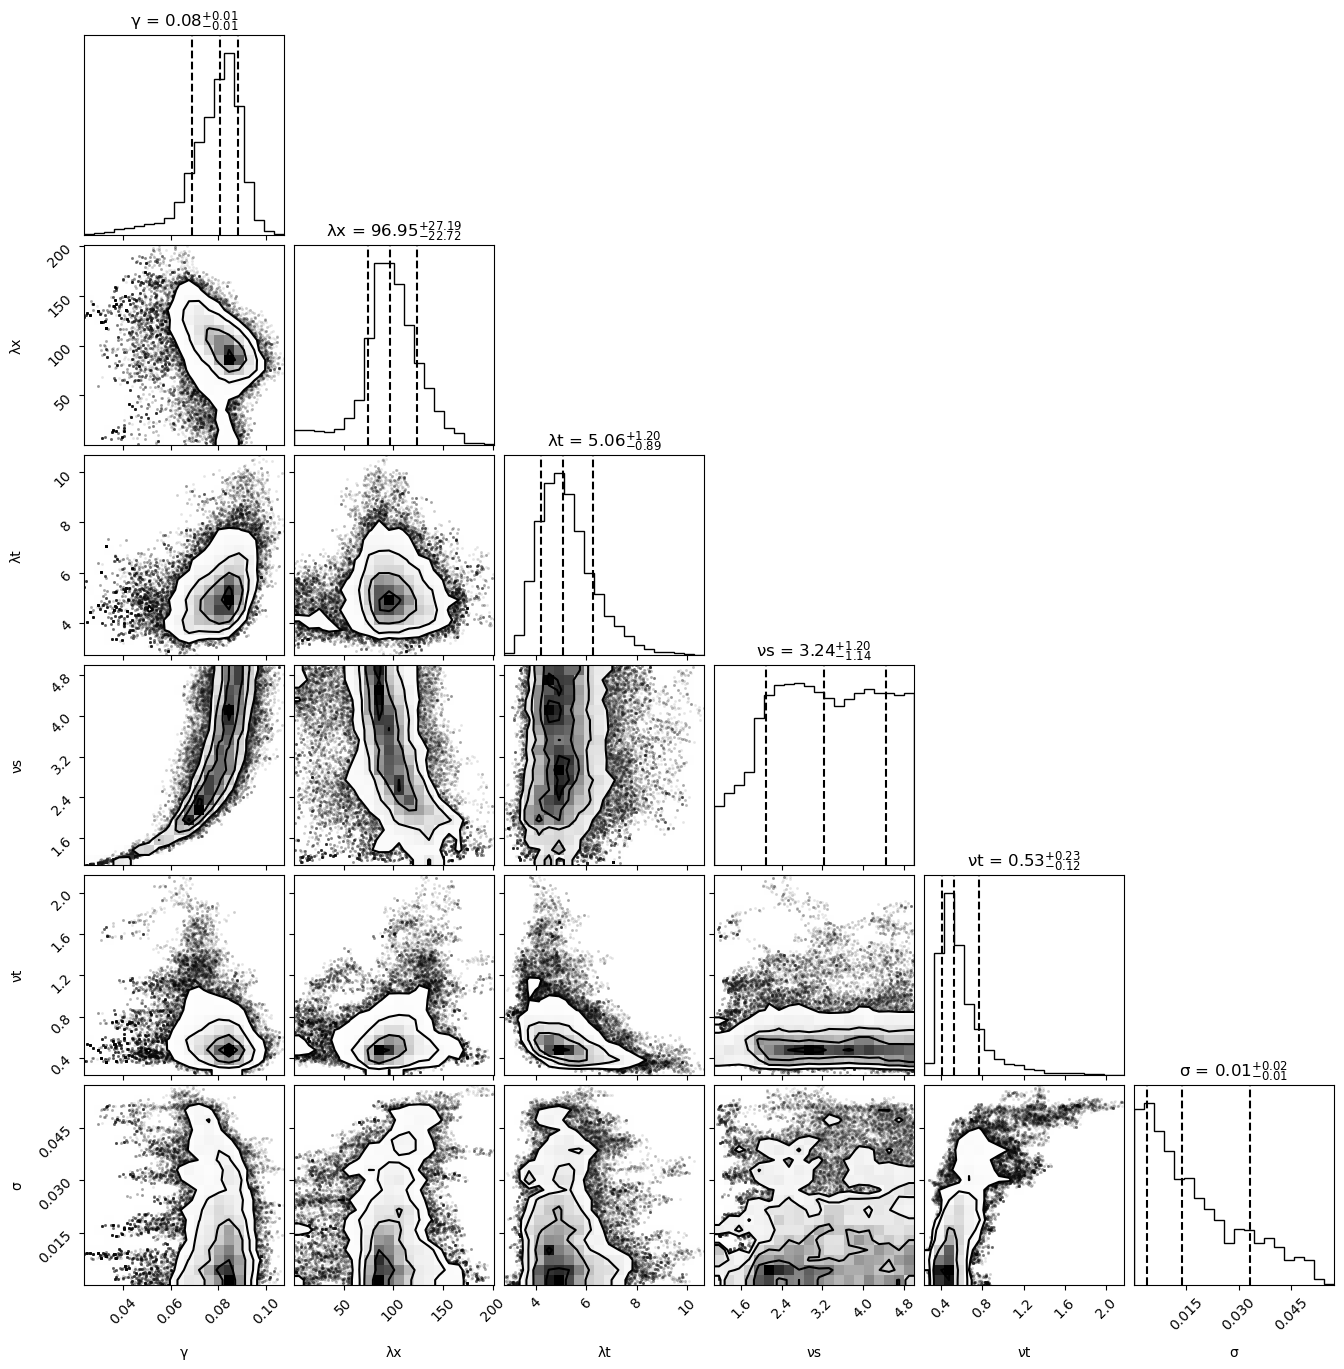

In [11]:
ds = mo
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

---
## drifter inference plot

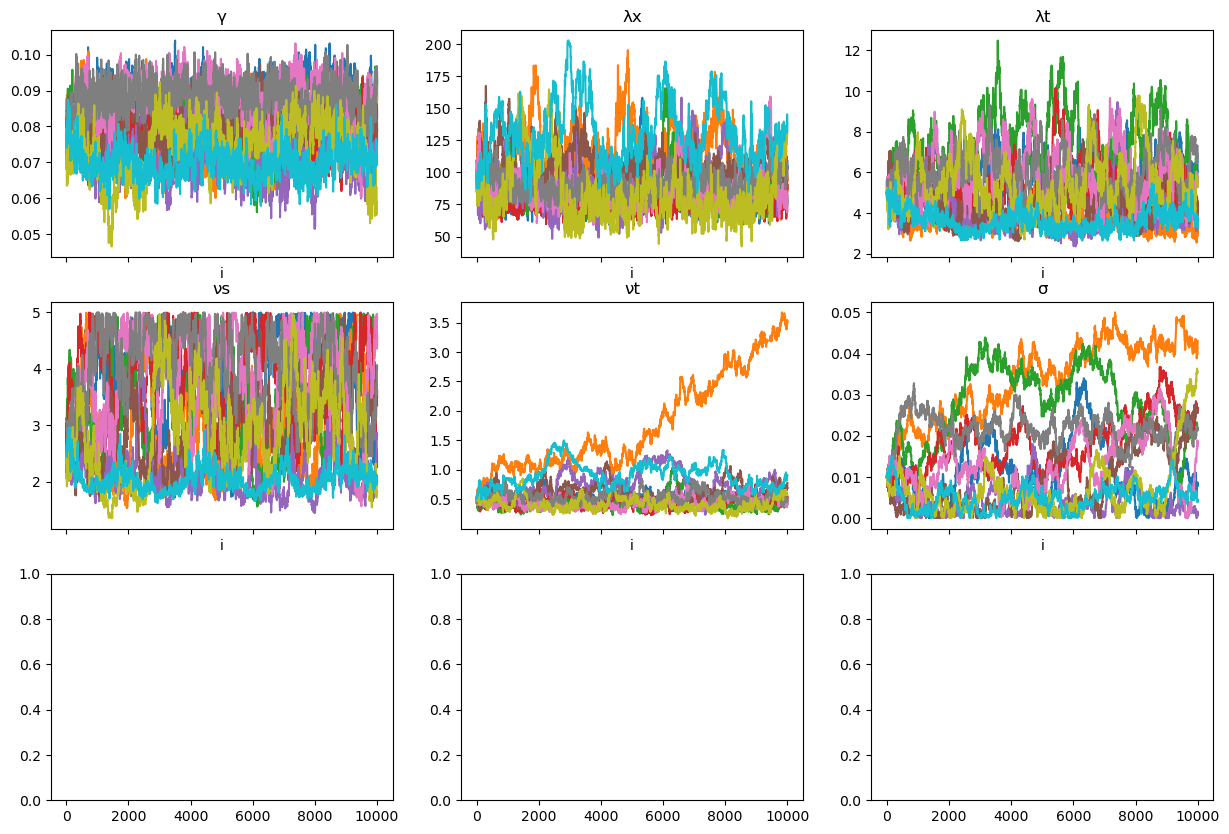

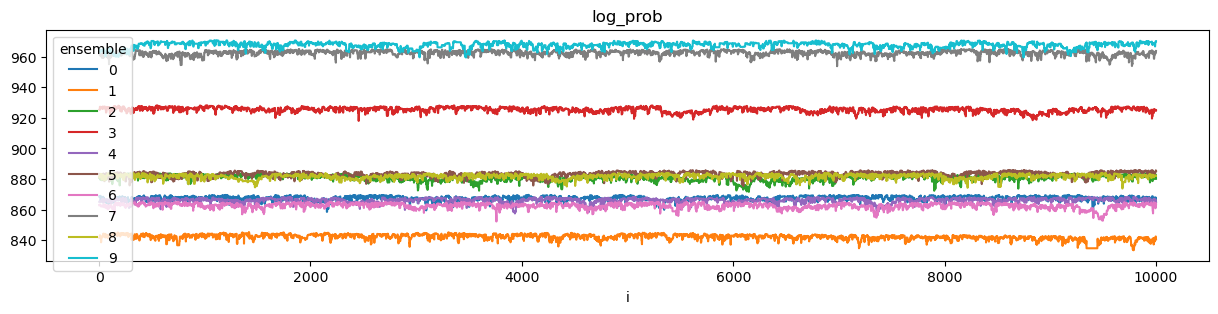

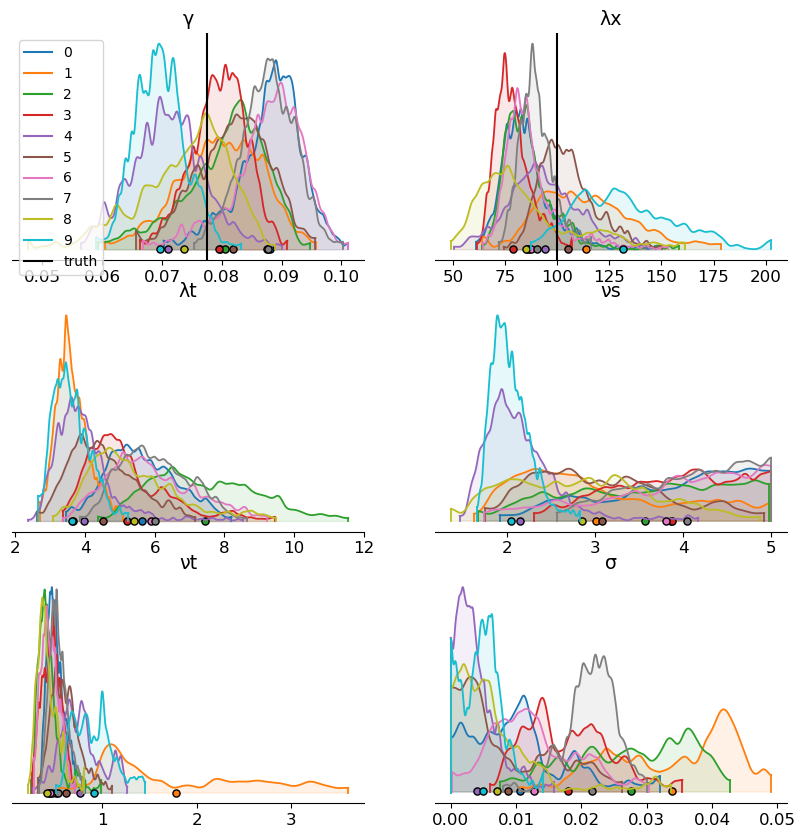

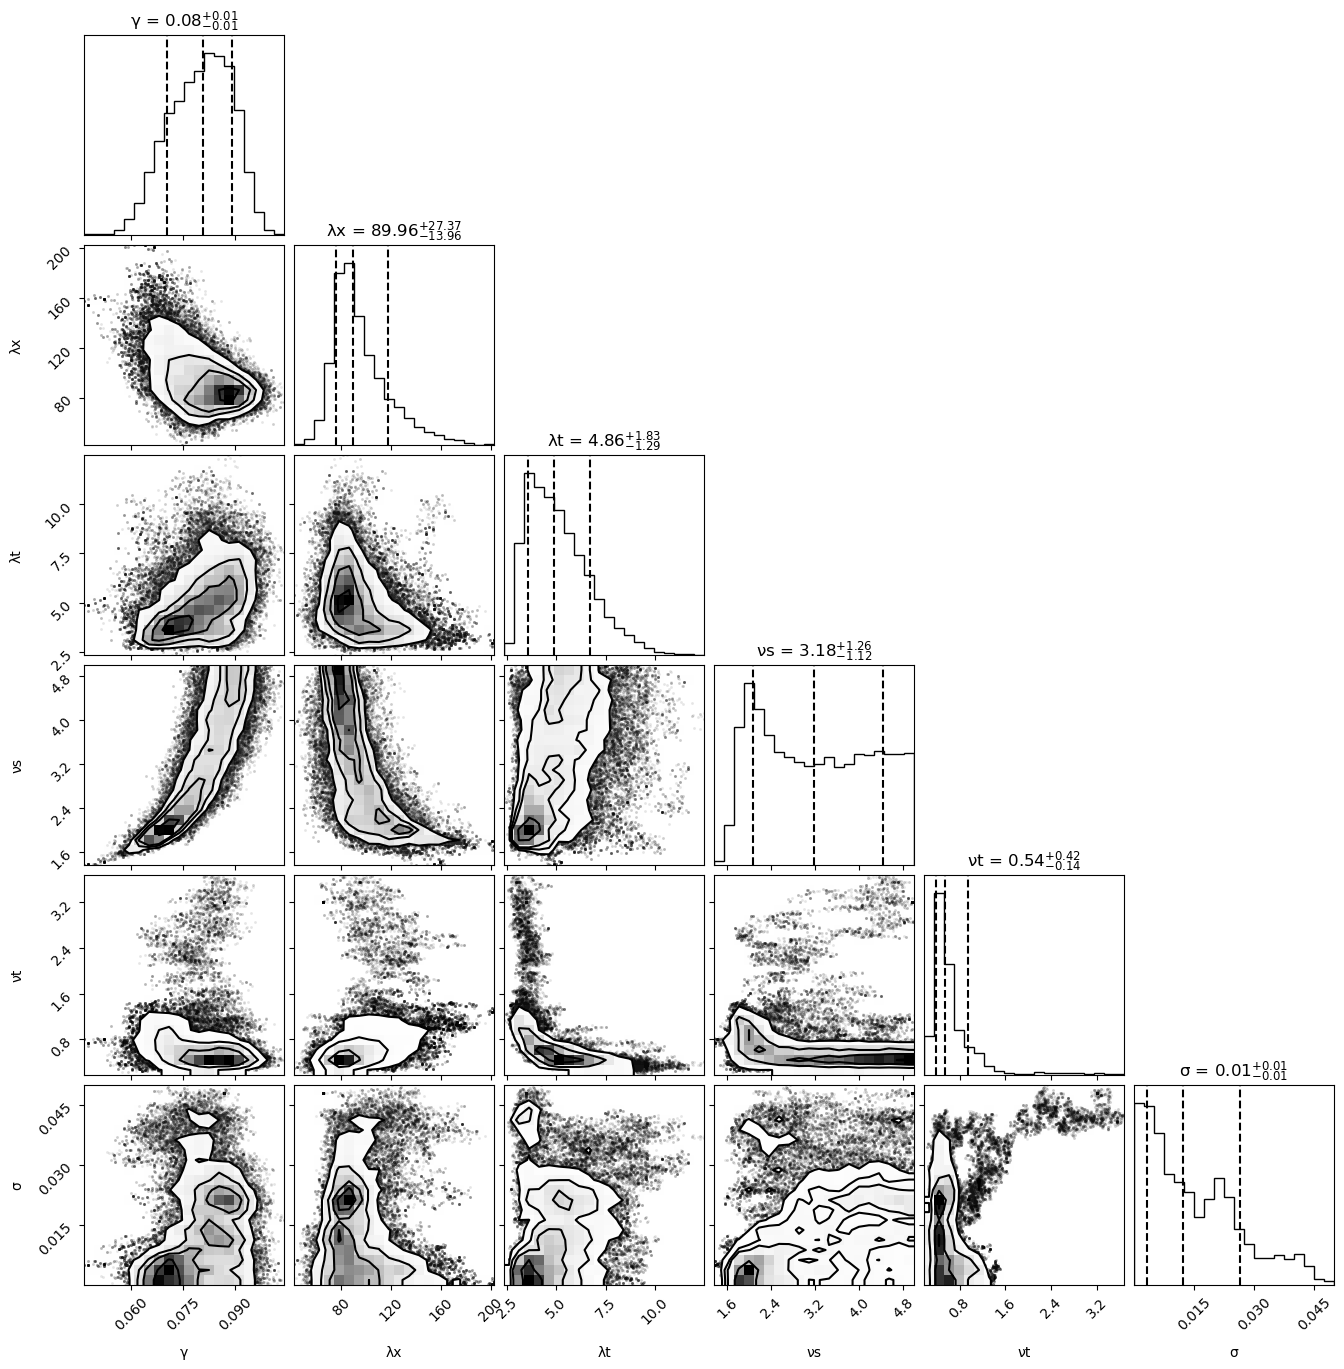

In [13]:
ds = dr
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)